In [ ]:
# Import basic stuffs

import os, sys, re, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import seaborn as sns
%pylab inline

# Figure 6: Improvement of peak-calling in snATAC-seq data for rare cell types

Analysis with called Peaks before versus after optimization.

In [1]:
# Basic location of podocyte
dir_data = "../data"
dir_satac_kidney = "%s/satac_kidney" % dir_data

## 6B:
gkmQC curves for pseudo-bulk reads of podocyte cells are shown before and after the optimization.<br>
Peak subsets within the pink box are the ones newly discovered by the optimization.<br>
The inset table shows the results of SNP-heritability analyses for two kidney- and one non-relevant traits for these newly identified peaks only.

(0.5, 1.0)

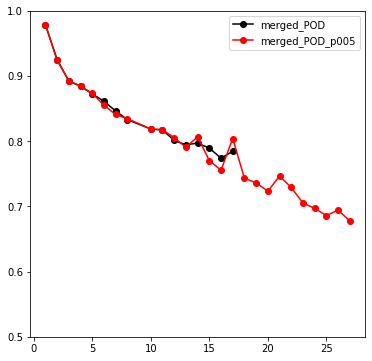

In [6]:
i = 0
plt.figure(figsize=(6, 6))
last_auc_li = []

tc = "POD" ## for podocytes
colors = ["black", "red"]

for prefix in ["merged_%s" % tc, "merged_%s_p005" % tc]:
    try:
        f = open("%s/%s.gkmqc/%s.gkmqc.eval.out" %\
                 (dir_satac_kidney, prefix, prefix))
    except:
        continue
        
    auc_list = []
    for line in f.readlines():
        txt, _, num, val, _ = line.split()
        if float(num) >= 5000:
            rank_n = int(txt.split('.')[-2][3:])
            auc_list.append((rank_n, float(val)))
    
    auc_list.sort(key=lambda x: x[0])
    plt.plot(*zip(*auc_list), '-o', zorder=2, label=prefix, color=colors[i])
    i += 1
       
plt.legend()
plt.ylim(0.5, 1.0)
#plt.savefig("../output/Figure_6B.pdf")

## S8B:
Comparison of peak counts before and after optimization.<br>
Each dot represents the kidney cell type. Size of the dots are the cell counts of the cell type in snATAC-seq data. 

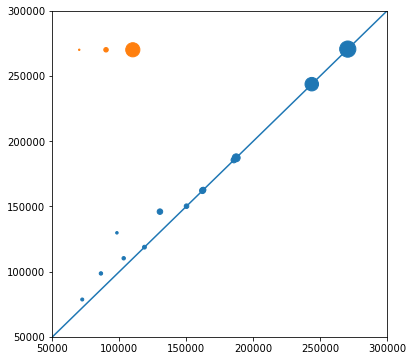

In [7]:
# cell types
ctype_cluster_dic = {
    'PT': [5, 6, 14],
    'PT-KIM1P': [18],
    'LH': [7, 9, 12, 20],
    'DCT': [1],
    'CNT': [11],
    'PC': [4],
    'ICA': [3],
    'ICB': [2],
    'PEC': [10],
    'POD': [17],
    'ENDO': [16],
    'MES-FIB': [19],
    'LEUK': [8]
}
# Cell types and Barcodes (for counting # of cells)
f = open("%s/cluster_info_cells_010321.tsv" % dir_satac_kidney)
f.readline()

ctype_barcode_dic = {}
for ctype in ctype_cluster_dic:
    ctype_barcode_dic[ctype] = []
    
for line in f.readlines():
    _, barcode, sample, cluster, ctype = line.split()
    for ctype in ctype_cluster_dic:
        if int(cluster) in ctype_cluster_dic[ctype]:
            ctype_barcode_dic[ctype].append(barcode)
f.close()

# load total peak counts
import subprocess

n_peaks_optz = []
n_peaks_orig = []
n_cells = []
name_cells = []

for ctype in ctype_cluster_dic:
    name_cells.append(ctype)
    
    # Cells
    n = len(ctype_barcode_dic[ctype])
    n_cells.append(n)
    
    # Original
    fi_peaks_orig = "%s/merged_%s.gkmqc/merged_%s.e300.bed" %\
    (dir_satac_kidney, ctype, ctype)
    f = open(fi_peaks_orig)
    n_peaks_orig.append(len(f.readlines()))
    f.close()
    
    # Optimized
    try:
        fi_peaks_optz = "%s/merged_%s.gkmqc/merged_%s.e300.optz.bed" %\
        (dir_satac_kidney, ctype, ctype)
        f = open(fi_peaks_optz)
        n_peaks_optz.append(len(f.readlines()))
        f.close()
    except:
        n_peaks_optz.append(n_peaks_orig[-1])

plt.figure(figsize=(6, 6))
s = list(map(lambda x: x / 50, n_cells))
plt.scatter(n_peaks_orig, n_peaks_optz, s=s)

lim = (50000, 300000)
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim)

# Legends
s = list(map(lambda x: x / 50, [100, 1000, 10000]))
plt.scatter([70000, 90000, 110000], [270000, 270000, 270000], s=s)
#plt.savefig("../output/Figure_S8B.pdf")

## S8C:
gkmQC curves for peaks called from pseudo-bulk reads of kidney cells.<br>
Dash lines are the gkmQC curves for optimized peaks.<br>
Peaks for total 5 cell-types the minimum AUC >0.75 were optimized. 

(0.5, 1.0)

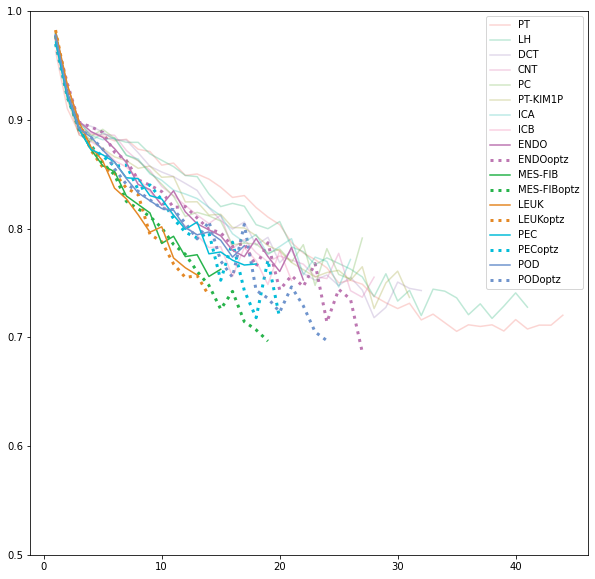

In [8]:
# for kidney samples

i = 0
plt.figure(figsize=(10, 10))

last_auc_li = []
color_list = [
    "#F3766E", "#2DB67B", "#A085BD", "#DB6CAA",\
    "#6AB144", "#A1A537", "#25BBAD", "#F067A1",\
    "#BD77B2", "#27B34B", "#E48825", "#03BCD8",\
    "#6F94CD"
]

i = 0
least_auc_dic = {}
for el in ["PT", "LH", "DCT", "CNT", "PC",\
           "PT-KIM1P", "ICA", "ICB", "ENDO",\
           "MES-FIB", "LEUK", "PEC", "POD"]:
    
    ##
    # normal
    auc_list = []
    f = open("%s/merged_%s.gkmqc/merged_%s.gkmqc.eval.out" %\
             (dir_satac_kidney, el, el))
    
    for line in f.readlines():
        txt, _, num, val, _ = line.split()
        auc_list.append((int(txt.split('.')[-2][3:]), float(val)))
    f.close()
    
    auc_list.sort(key=lambda x: x[0])
    least_auc_dic[el] = min(list(map(lambda x: x[1], auc_list)))
    
    if el in ["POD", "ENDO", "PEC", "MES-FIB", "LEUK"]:
        plt.plot(*zip(*auc_list), '-',\
                 zorder=2, label=el, color=color_list[i])
    else:
        plt.plot(*zip(*auc_list), '-',\
                 zorder=2, label=el, color=color_list[i], alpha=0.3)
    
    ##
    # optz
    if el in ["POD", "ENDO", "PEC", "MES-FIB", "LEUK"]:
        auc_list_optz = [] 
        f = open("%s/merged_%s_p005.gkmqc/merged_%s_p005.gkmqc.eval.out" %\
                 (dir_satac_kidney, el, el))
        for line in f.readlines():
            txt, _, num, val, _ = line.split()
            auc_list_optz.append((int(txt.split('.')[-2][3:]), float(val)))
        f.close()
        
        auc_list_optz.sort(key=lambda x: x[0])
        for rank, auc_score in auc_list_optz:
            if auc_score < 0.7:
                break
        plt.plot(*zip(*auc_list_optz[:rank-1]), ':',\
                 zorder=1, color=color_list[i], linewidth=3, label=el+"optz")
    
    i += 1
    
plt.legend()
plt.ylim(0.5, 1.0)
#plt.savefig("../output/Figure_S8C.pdf")

## S8D:
Red line shows the decrease of the minimum AUC scores in gkmQC curve of the corresponded cell type according to the increase of cell counts,<br>
demonstrating the more significant optimization in the rare cell types. Cell types with red colors are minimum AUC >0.75.

Text(0, 0.5, 'least AUC')

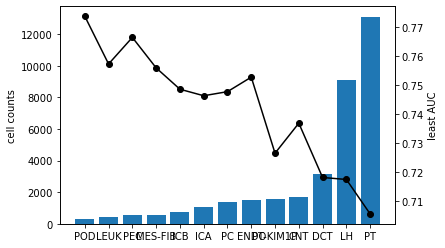

In [9]:
x = []
y = []
ctype_l = []
for ctype in ctype_barcode_dic:
    x.append(len(ctype_barcode_dic[ctype]))
    y.append(least_auc_dic[ctype])
    ctype_l.append(ctype)
    
x_s, y_s, ctype_s = zip(*sorted(zip(x, y, ctype_l), key=lambda x: x[0]))

fig, ax1 = plt.subplots()
ax1.bar(ctype_s, x_s)
ax1.set_ylabel("cell counts")
ax2 = ax1.twinx()
ax2.plot(ctype_s, y_s, "o-", color="black")
ax2.set_ylabel("least AUC")
#plt.savefig("../output/Figure_S8D.pdf")

## S8F:
The comparison of SNP-heritability between optimized and default peaks for 5 cell-types.<br>
Likely Fig. 5d; Continued from [LDSC analysis](Figure_06_preproc.ipynb)

In [4]:
import glob, subprocess, os

dir_data_ldsc = "../data/ldsc"

ctypes_optz = ["POD", "PEC", "ENDO", "MES-FIB", "LEUK"]
for ctype in ctypes_optz:
    print(ctype)
    prefix = "3way_%s_%s_p005" % (ctype, ctype)
    for gwas in ["egfr", "uacr", "scz"]:
        print(gwas)
        fi = glob.glob("%s/%s/ldsc_baseLD22_%s*.results" % (dir_data_ldsc, prefix, gwas))[0]
        print(subprocess.getoutput("tail -n 3 %s | cut -f 3,10" % fi))

POD
egfr
0.01118983113093235	1.9318947336733143
0.04100506591852798	0.7969528867098546
0.4712340167401484	4.4114892933270875
uacr
0.0059390037828708974	0.8727666175430397
0.09290922822510311	3.35705204940074
0.2544553845899691	2.3063347048754346
scz
0.0023628451891186445	0.7123826732388955
0.022521955662586118	0.009967005918266703
0.04455250249381359	-1.2625708016976678
PEC
egfr
0.01860527271580037	1.1642371507249636
0.0224695585415112	1.0117617756800317
0.4566878869318909	3.534160496501754
uacr
-0.004849059868084487	-1.359075451379007
0.019734929950783294	0.7811428194389571
0.27355694074763637	2.72598398600736
scz
-0.0028849840913031124	-1.1921725207708356
0.008903274256719705	0.1693008557692536
0.07515315817920348	0.09155565106340267
ENDO
egfr
-0.0029283863045292623	-1.003729726789992
0.05275136036962436	2.0258994559406727
0.5114341930645312	3.822854335839134
uacr
0.001005201381497521	0.04232211255586637
0.07419026888946349	3.1996796080469063
0.29114893809801007	2.9218182709852956
sc

## S9B:
Comparison of peak counts before and after optimization.<br>
Each dot represents the kidney cell type. Size of the dots are the cell counts of the cell type in snATAC-seq data. 

In [ ]:
# Load cell type lists
cell_barcode_dic = {}
f = open("../data/PBMC_10k_mdata.tsv")
f.readline()
for line in f.readlines():
    line_tab = line.strip().split("\t")
    barcode = line_tab[0]
    cell_id = line_tab[-2]
    if not cell_id in cell_barcode_dic:
        cell_barcode_dic[cell_id] = []
    cell_barcode_dic[cell_id].append(barcode)
f.close()

for ctype in cell_barcode_dic:
    print(ctype, len(cell_barcode_dic[ctype]))
prefix_li = ["CD14M", "BC", "NK", "CD8E",\
             "DNT", "CD4M", "CD4N", "CD8N",\
             "CD16M", "DC", "PRBC", "PDC"]